In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 31.0 MB/s 
     |████████████████████████████████| 120 kB 68.0 MB/s 
     |████████████████████████████████| 6.6 MB 65.0 MB/s 


In [ ]:
import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

from transformers import BertTokenizer, BertConfig
from transformers import BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using PyTorch version: 1.12.1+cu113 Device: cuda [Tesla T4]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

In [ ]:
x = '[CLS]'+ train.premise.values + '[SEP]' + train.hypothesis.values + '[SEP]'
y = train.label.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [ ]:
##download the tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
from tqdm import tqdm

tokenized_train = [tokenizer.tokenize(s) for s in tqdm(x_train)]
tokenized_test  = [tokenizer.tokenize(s) for s in tqdm(x_test)]


 76%|███████▌  | 2756/3636 [49:55<15:56,  1.09s/it]  

100%|██████████| 3636/3636 [00:02<00:00, 1485.13it/s]


In [ ]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)] for t in tokenized_test]

print ("The truncated tokenized first training sentence:")
print (tokenized_train[0])

The truncated tokenized first training sentence:
['[CLS]', 'เมื่อ', '##การ', '##ต', '##ัด', '##ส', '##ิน', '##ใ', '##จ', '##เ', '##ห', '##ล', '##่า', '##นี้', '##ไ', '##ด้', '##เ', '##กิด', '##ข', '##ึ', '##้น', '##ไ', '##ป', '##แ', '##ล้ว', ',', 'อ', '##ง', '##ค์', '##กร', 'C', '##IO', '[UNK]', '[SEP]', 'อ', '##ง', '##ค์', '##กร', 'C', '##IO', 'ม', '##ัก', '##จ', '##ะ', '##มี', '##บ', '##ุ', '##ค', '##ลา', '##กร', '##เ', '##จ', '##็', '##ด', '##ค', '##น', '##ที่', '##ค', '##อย', '##ใ', '##ห', '##้', '##การ', '##ส', '##น', '##ับ', '##ส', '##น', '##ุ', '##น', '##ใน', '##กร', '##ณ', '##ี', '##เ', '##ห', '##ล', '##่า', '##นี้', '[SEP]']


In [ ]:
ids_train = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_train]
ids_train = np.array([np.pad(i, (0, MAX_LEN_TRAIN-len(i)),
                             mode='constant') for i in ids_train])

ids_test = [tokenizer.convert_tokens_to_ids(t) for t in tokenized_test]
ids_test = np.array([np.pad(i, (0, MAX_LEN_TEST-len(i)),
                            mode='constant') for i in ids_test])

print ("The indices of the first training sentence:")
print (ids_train[0])

The indices of the first training sentence:
[   101  72549  53123  30011  78654  28767  26027 111434  46856 111431
 111424  20507  38999  80420 111435  81831 111431 100631  80814 111428
  49512 111435  49292 111432  92529    117   1436  19197  60350  95707
    140  37174    100    102   1436  19197  60350  95707    140  37174
   1425  69365  46856  22598  97561  49097  53936  31256  61888  95707
 111431  46856 111437  22123  31256  16000  18203  31256 100145 111434
 111424  35933  53123  28767  16000 102269  28767  16000  53936  16000
  75890  95707  62914  18260 111431 111424  20507  38999  80420    102
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]


In [ ]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)

for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

In [ ]:
(train_inputs, validation_inputs,
 train_labels, validation_labels) = train_test_split(ids_train, y_train,
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks,
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(y_test)
test_masks  = torch.tensor(amasks_test)

In [ ]:
BATCH_SIZE = 32

print('Datasets:')
print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=BATCH_SIZE)
print(len(train_data), 'documents')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'documents')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'documents')

Datasets:
Train: 7635 documents
Validation: 849 documents
Test: 3636 documents


In [ ]:
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=3)
model.cuda()
print('Pretrained BERT model "{}" loaded'.format(model_name))

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Pretrained BERT model "bert-base-multilingual-cased" loaded


In [ ]:
EPOCHS = 4
WEIGHT_DECAY = 0.01
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters()
                if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters()
                if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS,
                                 num_training_steps =len(train_dataloader)*EPOCHS)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()

  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Zero gradient buffers
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()
    scheduler.step()

    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))

from sklearn.metrics import confusion_matrix, classification_report

def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0

  predicted_labels = list()
  true_labels = list()

  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)

    true_labels.extend(labels)
    predicted_labels.extend(predictions)
    n_all += len(labels)

  print('Accuracy: [{}/{}] {:.4f}'.format(n_correct, n_all,
                                          n_correct/n_all))
  print('Classification report:')
  print(classification_report(true_labels, predicted_labels))
  print('Confusion matrix:')
  cm = confusion_matrix(true_labels, predicted_labels)
  print(cm)

In [ ]:
train_lossv = []
for epoch in range(1, EPOCHS + 1):
    print()
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)


Train Epoch: 1 [0/7635 (0%)]	Loss: 0.832393
Train Epoch: 1 [6400/7635 (84%)]	Loss: 0.779963

Validation set:
Accuracy: [517/849] 0.6090
Classification report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       301
           1       0.65      0.55      0.59       281
           2       0.55      0.68      0.61       267

    accuracy                           0.61       849
   macro avg       0.61      0.61      0.61       849
weighted avg       0.62      0.61      0.61       849

Confusion matrix:
[[182  47  72]
 [ 51 154  76]
 [ 49  37 181]]

Train Epoch: 2 [0/7635 (0%)]	Loss: 0.619747
Train Epoch: 2 [6400/7635 (84%)]	Loss: 0.460911

Validation set:
Accuracy: [540/849] 0.6360
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       301
           1       0.65      0.65      0.65       281
           2       0.62      0.60      0.61       267

    accuracy     

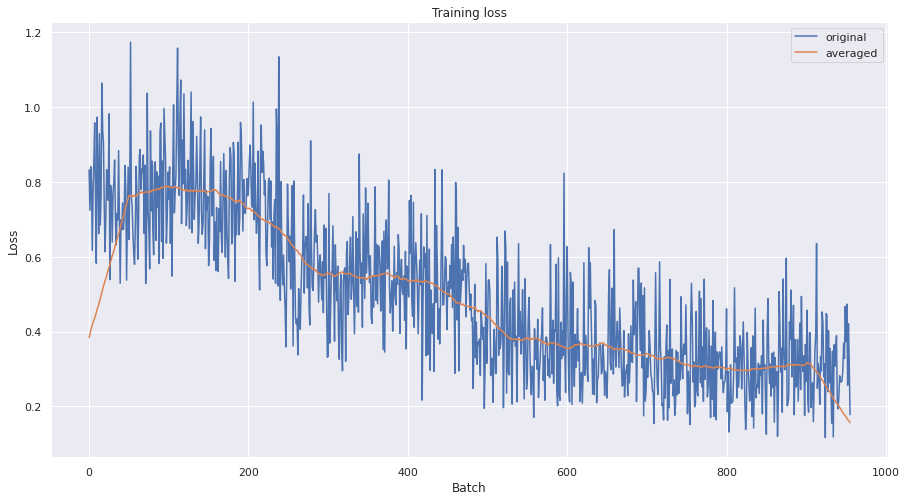

In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101,
         label='averaged')
plt.legend(loc='best')
plt.show()

In [ ]:
print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [2322/3636] 0.6386
Classification report:
              precision    recall  f1-score   support

           0       0.70      0.63      0.66      1237
           1       0.61      0.66      0.63      1147
           2       0.62      0.63      0.63      1252

    accuracy                           0.64      3636
   macro avg       0.64      0.64      0.64      3636
weighted avg       0.64      0.64      0.64      3636

Confusion matrix:
[[774 207 256]
 [157 756 234]
 [177 283 792]]
